In [108]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import en_core_web_lg
import corenlp
from stanfordcorenlp import StanfordCoreNLP
from nltk.tree import Tree
import json
import re
import string
import time
from sklearn.model_selection import train_test_split

pd.set_option('display.max_colwidth', 300)

In [2]:
nlp = en_core_web_lg.load()

In [ ]:
df = pd.read_csv('dataset/phrases_cleaned_1522422847595.csv')

* there is spelling errors. Probably it's an opportunity to create more examples. Just use grammarly to fix errors and add fixed examples into dataset
* Some notes on phrases
  * ambigous `who rated my page`
  * Post is negative, not reply. Probably in future we will add sentiments for replies `'Find all Marjories that replied to post negatively and downloaded exhibitor file'`
  * Poll -> Post `Find everyone who answered 'Yes' in a poll and wrote positive poll and clicked ablitech ad`
  * "Downloaded something" not realistic `Search all people with last name White who liked at least one post by Shawna Potter and downloaded something from 'sponsor' type page`
  * For now we don't have search for negative or neutral enjoyment `wasn't impressed by the event.`
  * bio -> big `Search for profiles with "bio" who liked post on biplane and replied to Cooper`
  * looks not realistic `Search attendees: ` ` x9 times `
  * looks not realistic `*3`
  * look not realistic `Find attendees:`
  * wrong ` who created a post on page with word 'easy' in text`
  * Super cool `either .. or ..` `neither .. nor ..`
  * interesting idea `name = 'Lavern'`
  * not realistic `Find the biplane people`
  * cool, but too hard; maybe need to postpone `post that can be said to be a positive one`
  * kinda cool, postpone `If there exists a post with a positive sentiment which was liked by a user who attended a single event and has a bio containing a "biplane" word -- present such users to me!`
  * not sure this is valid sentence `93 Find attendees where reply to Stacy Vaughn and phone number 7699165982 and post has "rare"`
  * ambigous `Find attendees who liked a page nine time and the page contains 'gargoyle'`
  * extra end `and and`
  * duplicate `find everyone with deviantart.com as their website`
  * what page? `saw this page`
  * too complex for users to come up `someone else's post`
  * We can't search by the note content `note that contains` `note containing the word 'concussion'` `note with the word 'concussion'` `created a note containing 'concussion'`
  * There is no such filter now `profile info contains (290) 448-8241`
  * spelling exhibotr
  * duplicate `positive positive`
  * missed closed quote `'coastal`

### Points on how to split:
* we can split on `,?and`, `,?as well as`, `,?or`, `,`,`but`,`also`, 
  * but not here: `Find attendees who rated any page four times and participated in poll and answered yes to any question as well as downloaded a file from page with 'exhibitor' type`
* we can split on `who`, `that`:
  * `Find attendees with name Marjorie who replied to`
  * `Find all Marjories that replied to negative post and downloaded exhibitor file`
* leave only `n't` from `don't`,`isn't`, etc
* remove punctuation
* will need to do this automaticaly

In [ ]:
df_splitted = df.assign(splitted_phrase = df.phrase.str.split(r" and |, ?").apply(json.dumps))
df_splitted[['id', 'splitted_phrase']].to_csv('dataset/phrases_splitted', index=False)

### Points on how to prepare data for classification
* Replace all substrings with special values

In [ ]:
INTERP_VALUES = {'first-name':     ["Altagracia", "Valarie", "Maya", "Lavern", "Chante", "Milly", "Erinn", "Stephenie", "Nancie", "Saran", "Emery", "Kate", "Tarah", "Vida", "Rosana", "Petra", "Carisa", "Vashti", "Marjorie", "Madonna"],
   'last-name':      ["Smith", "Johnson", "Williams", "Jones", "Brown", "Davis", "Miller", "Wilson", "Moore", "Taylor", "Anderson", "Thomas", "Jackson", "White", "Harris", "Martin", "Thompson", "Garcia", "Martinez", "Robinson", "Clark", "Rodriguez", "Lewis", "Lee", "Walker"],
   'company':        ["A. O. Smith", "A. Schulman", "A&W Restaurants", "a21, Inc.", "Aaron's, Inc.", "Abbott Laboratories", "AbbVie", "Abercrombie & Fitch", "Ablitech, Inc.", "ABM Industries", "ABS Capital Partners", "ABX Air", "AC Lens", "Academi", "Accenture Plc", "Access Systems Americas, Inc.", "ACCO Brands", "Accuquote", "Accuride Corporation", "Ace Hardware", "Acme Fresh Market", "ACN Inc.", "Acsis Inc.", "Activision Blizzard", "Activision", "Blizzard", "Acuity Brands", "Acuity Insurance"],
   'position':       ["Accountant", "Accountant Systems", "Acquisition Management Intern", "Actuarial Analyst", "Actuary", "Administrative Generalist/Specialist", "Affordable Housing Specialist", "Analyst", "Appraiser", "Archaeologist", "Area Systems Coordinator", "Asylum or Immigration Officer", "Attorney/Law Clerk", "Audience Analyst", "Audit Resolution Follow Up", "Auditor", "Behavioral Scientist", "Biologist, Fishery", "Biologist, Marine", "Biologist, Wildlife", "Budget Analyst", "Budget Specialist", "Business Administration Officer", "Chemical Engineer", "Chemist", "Citizen Services Specialis"],
   'location':       ["Afghanistan", "Albania", "Algeria", "Andorra", "Angola", "Antigua & Deps", "Argentina", "Armenia", "Australia", "Austria", "Azerbaijan", "Bahamas", "Bahrain", "Bangladesh", "Barbados", "Belarus", "Belgium", "Belize", "Benin", "Bhutan", "Bolivia", "Bosnia Herzegovina", "Botswana", "Brazil", "Brunei", "Bulgaria", "Burkina", "Burundi", "Cambodia", "Cameroon", "Canada", "Cape Verde", "Central African Rep", "Chad", "Chile", "China", "Colombia", "Comoros", "Congo", "Congo {Democratic Rep}", "Costa Rica", "Croatia", "Cuba", "Cyprus", "Czech Republic", "Denmark", "Djibouti", "Dominica", "Dominican Republic", "East Timor", "Ecuador", "Egypt", "El Salvador", "Equatorial Guinea", "Eritrea", "Estonia", "Ethiopia", "Fiji", "Finland", "France", "Gabon", "Gambia", "Georgia", "Germany", "Ghana", "Greece", "Grenada", "Guatemala", "Guinea", "Guinea-Bissau", "Guyana", "Haiti", "Honduras", "Hungary", "Iceland", "India", "Indonesia", "Iran", "Iraq", "Ireland {Republic}", "Israel", "Italy", "Ivory Coast", "Jamaica", "Japan", "Jordan", "Kazakhstan", "Kenya", "Kiribati", "Korea North", "Korea South", "Kosovo", "Kuwait", "Kyrgyzstan", "Laos", "Latvia", "Lebanon", "Lesotho", "Liberia", "Libya", "Liechtenstein", "Lithuania", "Luxembourg", "Macedonia", "Madagascar", "Malawi", "Malaysia", "Maldives", "Mali", "Malta", "Marshall Islands", "Mauritania", "Mauritius", "Mexico", "Micronesia", "Moldova", "Monaco", "Mongolia", "Montenegro", "Morocco", "Mozambique", "Myanmar, {Burma}", "Namibia", "Nauru", "Nepal", "Netherlands", "New Zealand", "Nicaragua", "Niger", "Nigeria", "Norway", "Oman", "Pakistan", "Palau", "Panama", "Papua New Guinea", "Paraguay", "Peru", "Philippines", "Poland", "Portugal", "Qatar", "Romania", "Russian Federation", "Rwanda", "St Kitts & Nevis", "St Lucia", "Saint Vincent & the Grenadines", "Samoa", "San Marino", "Sao Tome & Principe", "Saudi Arabia", "Senegal", "Serbia", "Seychelles", "Sierra Leone", "Singapore", "Slovakia", "Slovenia", "Solomon Islands", "Somalia", "South Africa", "South Sudan", "Spain", "Sri Lanka", "Sudan", "Suriname", "Swaziland", "Sweden", "Switzerland", "Syria", "Taiwan", "Tajikistan", "Tanzania", "Thailand", "Togo", "Tonga", "Trinidad & Tobago", "Tunisia", "Turkey", "Turkmenistan", "Tuvalu", "Uganda", "Ukraine", "United Arab Emirates", "United Kingdom", "United States", "Uruguay", "Uzbekistan", "Vanuatu", "Vatican City", "Venezuela", "Vietnam", "Yemen", "Zambia", "Zimbabwe"],
   'enjoyment':      ["enjoyed", "not enjoyed"],
   'sentiment':      ["positive", "negative"],
   'email':          ["mthurn@live.com", "fangorn@hotmail.com", "euice@outlook.com", "rgarcia@optonline.net", "mxiao@yahoo.com", "firstpr@att.net", "webdragon@comcast.net", "jguyer@aol.com", "sakusha@yahoo.ca", "crandall@sbcglobal.net", "drezet@me.com", "miyop@icloud.com"],
   'phone':          ["(290) 448-8241", "(447) 865-0513", "(895) 592-8974", "(101) 892-2757", "(506) 934-8645", "(728) 690-5585", "(726) 292-2944", "(331) 408-2679", "(939) 771-3645", "(454) 726-1205", "(769) 916-5982", "(747) 180-7744", "(633) 561-7544", "(771) 171-3243", "(344) 842-7718"],
   'website':        ["mapy.cz", "ow.ly", "bbb.org", "mayoclinic.com", "soundcloud.com", "free.fr", "stumbleupon.com", "hugedomains.com", "apache.org", "wikia.com", "privacy.gov.au", "bandcamp.com", "sphinn.com", "deviantart.com", "berkeley.edu"],
   'social-network': ["google plus", "twitter", "google+", "facebook", "linkedin", "linked in"],
   'post-text':      ["My creativity is funky, and I want to run a marathon. You've got sick encounters, forever. #elbowism #randomtweet", "My job is debt free, and I want to pluck a cactus. Ridiculously good dinner dates, again.", "My cooking is being a jerk, and I want to go swimming. A hint of stellar banjo music, IMHO.", "My life is a pain, and I want to be heard. We need clammy candy, for the love of God.", "My boss is a joy, and I want to study holistic medicine. We need insane lies, really.", "My cat is debt free, and I want to level up. A clear case of better glitter, please.", "My job is so robust, and I want to go swimming. A hint of specific make-up, I say.", "My honesty is a pain, and I want to play hacky sack. A path towards creepy costumes, again."],
   'post-word':      ["mix", "finite", "phonograph", "fatal", "liver", "blizzard", "rare", "conqueror", "crawling", "accommodation", "gargoyle", "blackout", "coastal", "convulsion", "pragmatic", "beyond", "concussion", "free", "easy", "honey", "abomination", "eight", "captive", "big", "adsorbable", "airtight", "escapist", "feeling", "biplane"],
   'number':         [str(n) for n in list(range(10))],
   'mention':        ["Clay Arnold", "Sheryl Bradley", "Steven Owens", "Kristin Hansen", "Stephanie Jenkins", "Michelle Neal", "Lindsey Holt", "Philip Stephens", "Delia Flores", "Caleb Ramirez", "Lynn Boyd", "Andy Chandler", "Estelle Jimenez", "Stacy Vaughn", "Dorothy Larson", "Shawna Potter", "Sherman Cooper", "Hope Griffith", "Connie Mitchell", "Dolores Cummings"],
   'poll-answer':    ["Yes", "No", "Maybe"],
   'poll-question':  ["Do you sleep with your closet doors open?", "Do you take the shampoos and conditioner bottles from hotel?", "Do you sleep with your sheets tucked in?", "Have you ever stolen a street sign before?", "Do you like to use post-it notes?", "Do you cut out coupons but then never use them?", "Do you have freckles?", "Do you always smile for pictures?", "Do you ever count your steps when you walk?", "Have you ever peed in the woods?", "Do you ever dance even if there's no music playing?", "Do you chew your pens and pencils?", "Is it ok for guys to wear pink ?", "Do you still watch cartoons?"],
   'event':          ["Fluffy Bison'17", "Tired Kangaroos'18", "Clear Nightingales'12", "Swanky Elks'01", "Tall Frogs'12", "Present Larks'05", "Luxuriant Apes'04", "Deeply Seals'15", "Many Worms'13", "Ill Guineapigs'10", "Vagabond Panthers'12", "Happy Hippopotamuss'17"],
   'page-type':      ["session", "sponsor", "speaker", "exhibitor"],
   'file-name':      ["talk.pdf", "presentation.pptx", "workshop.doc"]}

INV_MAP = {v: k for k,vs in INTERP_VALUES.items() for v in vs}

In [ ]:
df = pd.read_csv('dataset/phrases_splitted_1522422847595.csv')
df.splitted_phrase = df.splitted_phrase.apply(json.loads)
mapcatted = pd.DataFrame([(row.id, phrase) for i,row in df.iterrows() for phrase in row.splitted_phrase],
                        columns=['id', 'phrase'])
mapcatted.phrase.unique()
#mapcatted.to_csv('dataset/phrases_unique_splitted_1522902786972.csv')

In [ ]:
mapcatted = pd.read_csv('dataset/phrases_unique_splitted_1522422847595.csv', index_col=None)

In [ ]:
# Replaces known named entities and search strings
mapcatted = mapcatted.drop_duplicates(subset=['phrase'])
vals = []
phrases = []

for _, row in mapcatted.iterrows():
    values = {}
    s = row['phrase']
    for p,k in INV_MAP.items():
        pt = re.compile("'?" + p + "'?")
        match = re.search(pt, s)
        if match:
            span = match.span()
            value = s[span[0]:span[1]]
            values[k] = value
            s = s[:span[0]] + '<' + k + '>' + s[span[1]:]
    vals.append(json.dumps(values))
    phrases.append(s)

mapcatted = mapcatted.assign(phrase = phrases, replacements = vals)
mapcatted.to_csv('dataset/ready_for_classification_1522902786972.csv', index=False)

In [6]:
wl = pd.read_csv('dataset/with_labels_1522902786972.csv', 
                 index_col=[0],
                 names=['id','phrase','replacements','label'],
                 skiprows=1)
wl['label'] = wl['label'].astype('category')
wl['label'].unique()

[post, like, ad, rate, poll, ..., reply, view, note, event, session]
Length: 12
Categories (12, object): [post, like, ad, rate, ..., view, note, event, session]

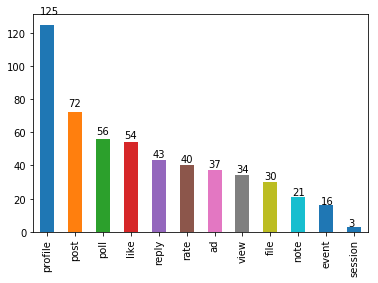

In [53]:
ax = wl['label'].value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.05))

Probably we need to upsample `note`,`event`,`session`. But for now try to train classifier on what we have to get some baseline

In [8]:
train, test = train_test_split(wl, test_size=0.3, stratify=wl['label'])

In [92]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, f1_score

categories = wl['label'].dtype.categories

def spacy_tokenizer(x):
    return [t.lemma_ for t in nlp(x)]

def conf_m(y_true, y_pred):
    return pd.DataFrame(confusion_matrix(y_true, y_pred), columns=y_true.dtype.categories, index=y_true.dtype.categories)

In [85]:
p1 = Pipeline([('vectorizer', CountVectorizer(tokenizer=spacy_tokenizer)),
               ('classifier', MultinomialNB())])
p1.fit(train['phrase'], train['label'])
print("Train score: ", p1.score(train['phrase'], train['label']))
print("Test score:", p1.score(test['phrase'], test['label']))
conf_m(test['label'], p1.predict(test['phrase']))

Train score:  0.954177897574124
Test score: 0.89375


,ad,event,file,like,note,poll,post,profile,rate,reply,session,view
ad,10,0,0,0,0,0,1,0,0,0,0,0
event,0,5,0,0,0,0,0,0,0,0,0,0
file,0,0,9,0,0,0,0,0,0,0,0,0
like,0,0,0,11,0,0,5,0,0,0,0,0
note,0,0,0,0,5,0,1,0,0,0,0,0
poll,0,0,0,0,0,17,0,0,0,0,0,0
post,0,0,0,1,0,0,21,0,0,0,0,0
profile,0,0,0,0,0,0,2,36,0,0,0,0
rate,0,0,0,0,0,0,0,0,11,0,0,1
reply,0,0,0,0,0,0,2,0,0,11,0,0


Let's try with tfidf vectorizer

In [58]:
p2 = Pipeline([('vectorizer', TfidfVectorizer(tokenizer=spacy_tokenizer)),
               ('classifier', MultinomialNB())])
p2.fit(train['phrase'], train['label'])
print("Train score: ", p2.score(train['phrase'], train['label']))
p2_pred_test = p2.score(test['phrase'], test['label'])
print("Test score:", p2_pred_test)
conf_m(test['label'], p2.predict(test['phrase']))

Train score:  0.9245283018867925
Test score: 0.84375


,ad,event,file,like,note,poll,post,profile,rate,reply,session,view
ad,10,0,0,0,0,0,1,0,0,0,0,0
event,0,2,0,0,0,0,0,3,0,0,0,0
file,0,0,9,0,0,0,0,0,0,0,0,0
like,0,0,0,10,0,0,6,0,0,0,0,0
note,0,0,0,0,2,0,3,0,1,0,0,0
poll,0,0,0,0,0,17,0,0,0,0,0,0
post,0,0,0,1,0,0,21,0,0,0,0,0
profile,0,0,0,0,0,0,0,38,0,0,0,0
rate,0,0,0,0,0,0,2,0,10,0,0,0
reply,0,0,0,0,0,0,5,0,0,8,0,0


Let's try to upsample examples

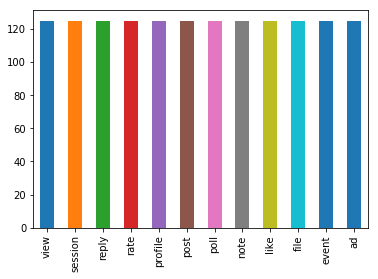

In [72]:
wl2 = wl.copy()
max_count = np.max(wl2['label'].value_counts())
addition = []
for cat in wl2['label'].dtype.categories:
    wl2_cat = wl2[wl2['label'] == cat]
    diff = max_count - len(wl2_cat)
    addition.append(wl2_cat.sample(n=diff, replace=True))
wl2 = wl2.append(addition, ignore_index=True).reset_index()
wl2['label'].value_counts().plot('bar')

Do a nb classification on upsampled data with count vectorizer

In [73]:
train2,test2 = train_test_split(wl2, test_size=0.3)

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer
p2 = Pipeline([('vectorizer', CountVectorizer(tokenizer=spacy_tokenizer)),
               ('classifier', MultinomialNB())])
p2.fit(train2['phrase'], train2['label'])
print("Train score: ", p2.score(train2['phrase'], train2['label']))
print("Test score:", p2.score(test2['phrase'], test2['label']))
conf_m(test2['label'], p2.predict(test2['phrase']))

Train score:  0.9723809523809523
Test score: 0.9711111111111111


,ad,event,file,like,note,poll,post,profile,rate,reply,session,view
ad,37,0,0,0,0,0,0,0,0,0,0,0
event,0,35,0,0,0,0,0,0,0,0,0,0
file,4,0,38,0,0,0,0,0,0,0,0,0
like,0,0,0,42,0,0,0,0,0,0,0,0
note,0,0,0,0,39,0,0,0,0,0,0,0
poll,0,0,0,0,0,36,0,0,0,0,0,0
post,0,0,0,1,1,0,29,1,0,0,0,0
profile,1,1,0,0,1,1,0,39,0,0,1,0
rate,0,0,0,0,0,0,0,0,37,0,0,0
reply,0,0,0,0,0,0,1,0,0,36,0,0


Well, that's much better

Let's play with upsampled data,
TfIdfVectorizer:

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer
p2 = Pipeline([('vectorizer', TfidfVectorizer(tokenizer=spacy_tokenizer)),
               ('classifier', MultinomialNB())])
p2.fit(train2['phrase'], train2['label'])
print("Train score: ", p2.score(train2['phrase'], train2['label']))
print("Test score:", p2.score(test2['phrase'], test2['label']))
conf_m(test2['label'], p2.predict(test2['phrase']))

Train score:  0.9676190476190476
Test score: 0.9688888888888889


,ad,event,file,like,note,poll,post,profile,rate,reply,session,view
ad,37,0,0,0,0,0,0,0,0,0,0,0
event,0,35,0,0,0,0,0,0,0,0,0,0
file,4,0,38,0,0,0,0,0,0,0,0,0
like,0,0,0,42,0,0,0,0,0,0,0,0
note,0,0,0,0,39,0,0,0,0,0,0,0
poll,0,0,0,0,0,36,0,0,0,0,0,0
post,0,0,0,1,2,0,26,0,0,3,0,0
profile,1,0,0,0,0,1,1,40,0,0,1,0
rate,0,0,0,0,0,0,0,0,37,0,0,0
reply,0,0,0,0,0,0,0,0,0,37,0,0


Lets breakdown errors on the upsampled count vectorizer case

In [107]:
p2_pred = p2.predict(test2['phrase'])
df_arg = {}
for cat in categories:
    df_arg[cat] = [precision_score(test2['label'] == cat, p2_pred == cat),
                   recall_score(test2['label'] == cat, p2_pred == cat),
                   f1_score(test2['label'] == cat, p2_pred == cat)]
pd.DataFrame(df_arg, index=['prec', 'rec', 'f1'])

,ad,event,file,like,note,poll,post,profile,rate,reply,session,view
prec,0.880952,1.0,1.000000,0.976744,0.95122,0.972973,0.962963,1.000000,1.0,0.925000,0.972222,1.0
rec,1.000000,1.0,0.904762,1.000000,1.00000,1.000000,0.812500,0.909091,1.0,1.000000,1.000000,1.0
f1,0.936709,1.0,0.950000,0.988235,0.97500,0.986301,0.881356,0.952381,1.0,0.961039,0.985915,1.0


In [110]:
displacy.render(nlp("Find attendees who rated any page four times and participated in poll and answered yes to any question as well as downloaded a file from page with 'exhibitor' type"), jupyter=True)